### Introduction
In this project we will create a model to analyze images of dogs and will output its guess of what breed it is.

We are using a dataset with 70 dog breeds with ~100 images per breed.

To create the model we used transfer learning with a variety of pretained models like: densenet, imagenet, ... then added new layers and fine tuning to make it work better for identifying dog breeds.

### Data Pre-Processing


In [1]:
# Import all the necessary modules

import os
import shutil
import tensorflow as tf
import keras
import pickle
import random
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from tensorflow.keras.preprocessing import image as image_utils
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import Sequence

from tensorflow.keras.applications.densenet import decode_predictions

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

In [2]:
# Get the pre-trained DenseNet model

model = tf.keras.applications.densenet.DenseNet121(
    include_top=True, weights='imagenet')

2024-04-21 16:58:47.684350: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-21 16:58:50.991965: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78911 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:07:00.0, compute capability: 8.0
2024-04-21 16:58:50.995078: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 78911 MB memory:  -> device: 1, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:4e:00.0, compute capability: 8.0
2024-04-21 16:58:51.000664: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/rep

In [3]:
# Funtions to show the images, load and process them to the correct input shape and make a prediction

def show_image(image_path):
    image = mpimg.imread(image_path)
    print(image.shape)
    plt.imshow(image)
    
def load_and_process_image(image_path):
    # Print image's original shape, for reference
    print('Original image shape: ', mpimg.imread(image_path).shape)
    
    # Load in the image with a target size of 224, 224
    image = image_utils.load_img(image_path, target_size=(224, 224))
    # Convert the image from a PIL format to a numpy array
    image = image_utils.img_to_array(image)
    # Add a dimension for number of images, in our case 1
    image = image.reshape(1,224,224,3)
    # Preprocess image to align with original ImageNet dataset
    image = preprocess_input(image)
    # Print image's shape after processing
    print('Processed image shape: ', image.shape)
    return image

def densenet_prediction(image_path):
    # Show image
    show_image(image_path)
    # Load and pre-process image
    image = load_and_process_image(image_path)
    # Make predictions
    predictions = model.predict(image)
    # Print predictions in readable form
    print('Predicted:', decode_predictions(predictions, top=3))

(224, 224, 3)


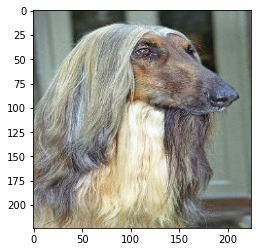

In [4]:
# Check that show_mimage works
show_image("test/Afghan/04.jpg")

In [5]:
processed_image = load_and_process_image("test/Afghan/04.jpg")

Original image shape:  (224, 224, 3)
Processed image shape:  (1, 224, 224, 3)


(224, 224, 3)
Original image shape:  (224, 224, 3)
Processed image shape:  (1, 224, 224, 3)


2024-04-21 16:59:00.664670: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8201


Predicted: [[('n02085936', 'Maltese_dog', 0.8320869), ('n02098413', 'Lhasa', 0.084464446), ('n02098286', 'West_Highland_white_terrier', 0.018734066)]]


2024-04-21 16:59:02.801207: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


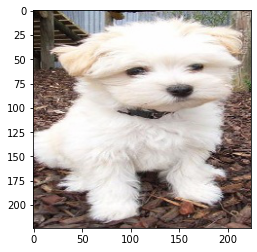

In [6]:
densenet_prediction("test/Maltese/04.jpg")

### Model setup

In [7]:
from tensorflow.keras.models import Model

num_classes = 70

# Define the base model (DenseNet121) without the top classification layer
base_model = tf.keras.applications.DenseNet121(
    include_top=False, weights='imagenet', input_shape=(224, 224, 3)
)

# Freeze the pre-trained layers
base_model.trainable = False

# Add a custom classification head
global_average_layer = GlobalAveragePooling2D()(base_model.output)
output_layer = Dense(num_classes, activation='softmax')(global_average_layer)

# Combine the base model with the custom classification head
model = Model(inputs=base_model.input, outputs=output_layer)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display a summary of the model architecture
#model.summary()


In [8]:
# Get current working directory
current_dir = os.getcwd()

# Define the directories for training, validation, and testing data
train_dir = os.path.join(current_dir, 'train')
valid_dir = os.path.join(current_dir, 'valid')
test_dir = os.path.join(current_dir, 'test')

# Define the ImageDataGenerator for training data
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2  
)

# Define the ImageDataGenerator for validation and testing data
valid_test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Create data generators for training, validation, and testing data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'  # set as training data
)

validation_generator = valid_test_datagen.flow_from_directory(
    valid_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = valid_test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)


Found 6390 images belonging to 70 classes.
Found 700 images belonging to 70 classes.
Found 702 images belonging to 70 classes.


In [9]:
history = model.fit(
    train_generator,
    epochs=10,
    batch_size=32,
    validation_data=validation_generator
)

test_loss, test_accuracy = model.evaluate(test_generator)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

Epoch 1/10
200/200 [==============================] - 22s 94ms/step - loss: 1.5841 - accuracy: 0.6592 - val_loss: 0.6506 - val_accuracy: 0.8929
Epoch 2/10
200/200 [==============================] - 16s 81ms/step - loss: 0.3977 - accuracy: 0.9121 - val_loss: 0.4759 - val_accuracy: 0.9343
Epoch 3/10
200/200 [==============================] - 16s 81ms/step - loss: 0.2663 - accuracy: 0.9399 - val_loss: 0.4476 - val_accuracy: 0.9300
Epoch 4/10
200/200 [==============================] - 17s 84ms/step - loss: 0.2013 - accuracy: 0.9551 - val_loss: 0.4306 - val_accuracy: 0.9386
Epoch 5/10
200/200 [==============================] - 16s 82ms/step - loss: 0.1626 - accuracy: 0.9620 - val_loss: 0.4296 - val_accuracy: 0.9443
Epoch 6/10
200/200 [==============================] - 16s 80ms/step - loss: 0.1351 - accuracy: 0.9706 - val_loss: 0.4443 - val_accuracy: 0.9329
Epoch 7/10
200/200 [==============================] - 16s 81ms/step - loss: 0.1126 - accuracy: 0.9764 - val_loss: 0.4341 - val_accuracy:

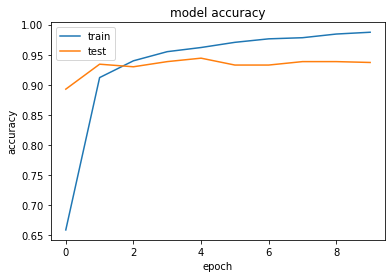

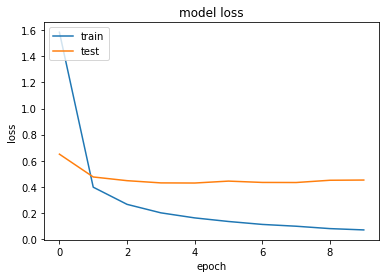

In [31]:
from matplotlib import pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

(224, 224, 3)
Original image shape:  (224, 224, 3)
Processed image shape:  (1, 224, 224, 3)
Predicted class: Bluetick, Probability: 0.9997338652610779
Predicted class: Bloodhound, Probability: 0.00020394526654854417
Predicted class: Cocker, Probability: 2.2513657313538715e-05


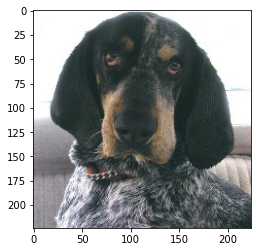

In [10]:
dog_species = [name for name in os.listdir('./test') if os.path.isdir(os.path.join('./test', name))]
dog_species.sort()
# print(dog_species)

def display_top_predictions(predictions, top=3):
    # Get the top predicted classes and corresponding probabilities
    top_indices = np.argsort(predictions)[0][-top:][::-1]
    top_probabilities = predictions[0][top_indices]
    
    # Print the top predictions
    for i in range(top):
        print(f"Predicted class: {dog_species[top_indices[i]]}, Probability: {top_probabilities[i]}")

        
def model_prediction(image_path):
    # Show image
    show_image(image_path)
    # Load and pre-process image
    image = load_and_process_image(image_path)
    # Make predictions
    predictions = model.predict(image)
    #Display top predictions
    display_top_predictions(predictions)
    
model_prediction("test/Bluetick/04.jpg")

Found 7946 files belonging to 70 classes.
Found 700 files belonging to 70 classes.


ValueError: Classification metrics can't handle a mix of multilabel-indicator and continuous-multioutput targets

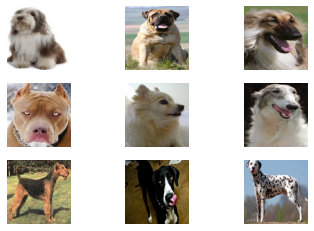

In [58]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import MultiLabelBinarizer
# Input image dimensions, etc.
resized_height = 224
resized_width = 224
num_channel = 3
num_classes = 14
batch_size = 128

y_pred_proba = model.predict(valid_images)

train_images = image_dataset_from_directory(
    './train', labels='inferred', label_mode='categorical',
     color_mode='rgb', batch_size=batch_size, image_size=(resized_height ,
    resized_width ), shuffle=True, seed=42,
    interpolation='bilinear', follow_links=False,
    crop_to_aspect_ratio=False)

valid_images = image_dataset_from_directory(
    './valid', labels='inferred', label_mode='categorical',
     color_mode='rgb', batch_size=batch_size, image_size=(resized_height ,
    resized_width ), shuffle=True, seed=42,
    interpolation='bilinear', follow_links=False,
    crop_to_aspect_ratio=False)

#Note that the images have been loaded with 3 color channels!
class_names = dog_species
y_test = []
# print(class_names)
for images, labels in train_images.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    #plt.title(class_names[labels[i]])
    plt.axis("off")
    # print(images[i])

for images, labels in valid_images:
    for i in range(len(labels)):
        y_test.append(labels[i])

    
cm = confusion_matrix(y_test, y_pred_proba)
ConfusionMatrixDisplay(cm).plot()
print(classification_report(y_test, y_pred_proba))

In [87]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

y_pred_proba = model.predict(valid_images)

for i in range(0, 700):
    for j in range(0, 70):
        if (y_pred_proba[i][j] > 0.5):
            y_pred_proba[i][j] = 1
        else:
            y_pred_proba[i][j] = 0

# for pred in y_pred_proba:
#     print(pred)
#     for prob in pred:
#         print(prob)
    #     if (prob > 0.5):
    #         prob = 1
    #     else:
    #         prob = 0
        # print(prob)

#Note that the images have been loaded with 3 color channels!
class_names = dog_species
    
y_test = []
for images, labels in valid_images:
    for i in range(len(labels)):
        y_test.append(labels[i])

# print(y_test)
# print(y_pred_proba)

cm = confusion_matrix(y_test, y_pred_proba)
ConfusionMatrixDisplay(cm).plot()
print(classification_report(y_test, y_pred_proba))

ValueError: multilabel-indicator is not supported

### Hyperparameter tuning

### Results

### Discussion